# Parnian Taheri - 99106352 - Homework 1

In [13]:
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Load .mat file
mat_data = scipy.io.loadmat('Data_hoda_full.mat')

In [15]:
#Train and test split
original_data = mat_data['Data'][0:4000]
y_train = mat_data['labels'][0:3000].ravel()
y_test = mat_data['labels'][3000:4000].ravel()

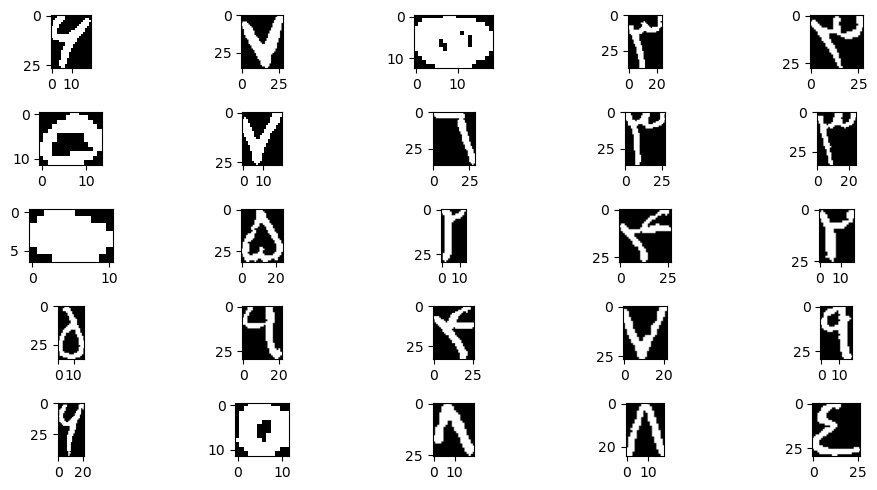

In [16]:
#plot
n = 5
fig, axs = plt.subplots(n, n, figsize=(10, 5))
for i in range(n):
    for j in range(n):
        axs[i, j].imshow(original_data[5*i + 4*j][0], cmap='gray')
plt.tight_layout()
plt.show()

## Resize and zero padding

In [17]:
#Find maximum size of indexes
x = np.zeros([4000,2])
for i in range(3000):
    x[i] = original_data[i][0].shape
max1 = math.floor(max(x.T[0]))
max2 = math.floor(max(x.T[1]))
print("The maximum size of the first index is:", max1,"\nThe maximum size of the second index is:", max2)

The maximum size of the first index is: 54 
The maximum size of the second index is: 45


In [18]:
#Zero padding
def zero_padding(original_data, max1, max2):
    temp =  np.zeros([max1,max2])
    data = np.zeros([4000,max1,max2])
    for i in range(4000):
        x = original_data[i][0].shape
        zpad1 = math.floor((max1 - x[0])/2)
        zpad2 = math.floor((max2 - x[1])/2)
        temp[zpad1:zpad1 + x[0], zpad2:zpad2 + x[1]] = original_data[i][0]
        data[i] = temp
    return data

data = zero_padding(original_data, max1, max2)

## Feature Extraction

### Zoning

In [19]:
def zone_image(image, num_rows, num_cols):
    # Calculate the size of each zone
    image_quantity = image.shape[0]
    zone_height = image.shape[1] // num_rows
    zone_width = image.shape[2] // num_cols
    output = np.zeros(image.shape)

    # Iterate over rows and columns to create zones
    for k in range(image_quantity):
        zones = []
        for i in range(num_rows):
            for j in range(num_cols):
                start_row = i * zone_height
                end_row = (i + 1) * zone_height
                start_col = j * zone_width
                end_col = (j + 1) * zone_width

                # Extract the zone from the image
                zone = image[k][start_row:end_row, start_col:end_col]
                output[k][start_row:end_row, start_col:end_col] = np.mean(zone)
    return output

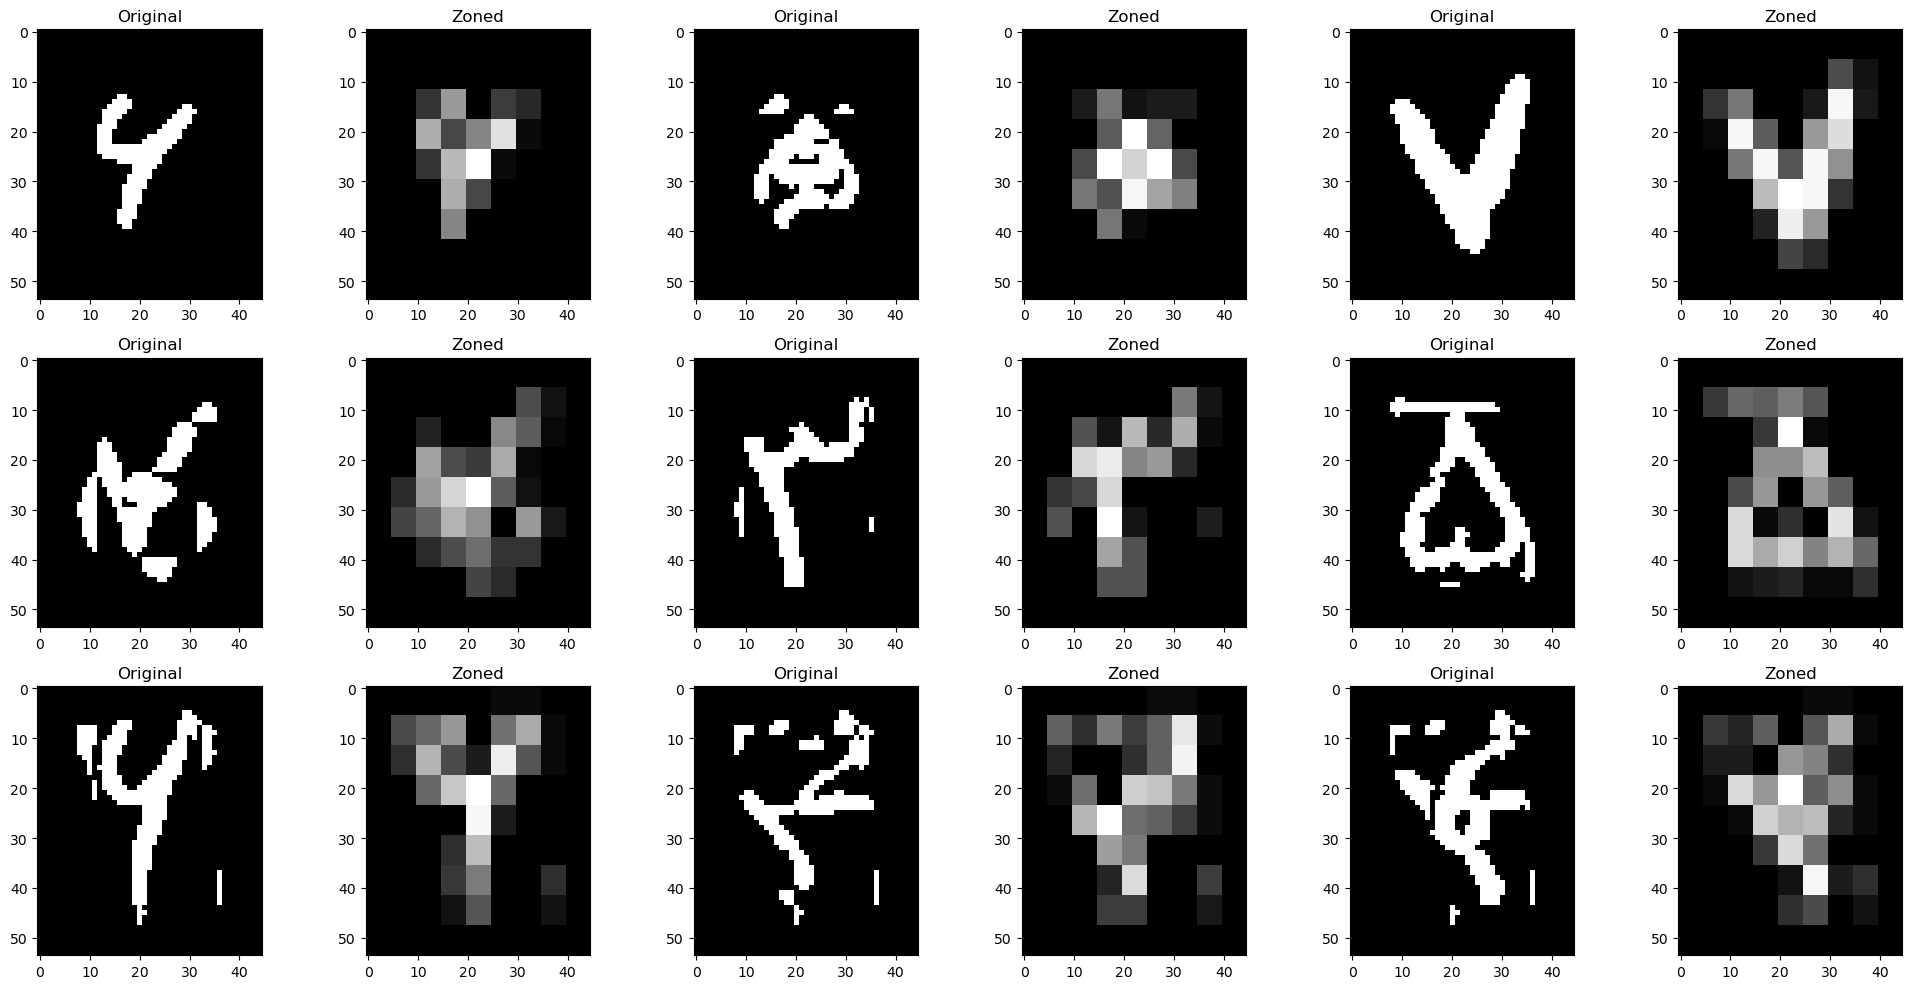

In [20]:
# Define the number of rows and columns for zoning
num_rows = 9
num_cols = 9

# Zone the image
zoned_image = zone_image(data, num_rows, num_cols)

#plot
n = 3
fig, axs = plt.subplots(n, n*2, figsize=(20, 10))
for i in range(n):
    for j in range(n):
        axs[i, 2*j].imshow(data[10*i + 2*j], cmap='gray')
        axs[i, 2*j].set_title('Original')
        axs[i, 2*j+1].imshow(zoned_image[10*i + 2*j], cmap='gray')
        axs[i, 2*j+1].set_title('Zoned')
plt.tight_layout()
plt.show()

# Convert to 2D data
nsamples, nx, ny = zoned_image.shape
zoned_vector = zoned_image.reshape((nsamples,nx*ny))

### Horizontal and vertical histogram

In [21]:
def hist_image(image):
    horizontal_histogram = np.sum(image, axis=2)
    vertical_histogram = np.sum(image, axis=1)
    return horizontal_histogram, vertical_histogram

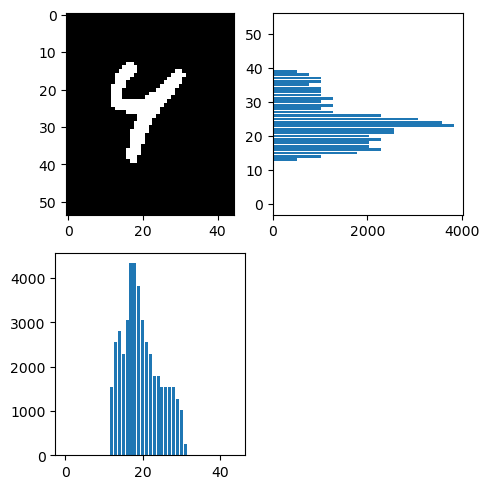

In [22]:
h_hist, v_hist = hist_image(data)
hist = np.concatenate((h_hist, v_hist), axis = 1)

#plot
m = 0 #mth image
fliped =  np.flip(np.flip(v_hist))
plt.figure(figsize=(5, 5))
plt.subplot(2,2,1)
plt.imshow(data[m],cmap = 'gray')
plt.subplot(2,2,2)
plt.barh(range(len(h_hist[m])), h_hist[m])
plt.subplot(2,2,3)
plt.bar(range(len(v_hist[m])),v_hist[m]) 
plt.tight_layout()
plt.show()

In [23]:
# Only by zoning
X_train_zoning =  zoned_vector[0:3000]
X_test_zoning = zoned_vector[3000:4000]

In [25]:
# Only by histogram
X_train_hist =  hist[0:3000]
X_test_hist = hist[3000:4000]

## Classifiers

In [13]:
def knn(x_train, x_test, y_train, y_test, k):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    return y_pred

def bayes(x_train, x_test, y_train, y_test):
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    return y_pred

def decision_tree(X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def random_forest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

In [14]:
def report(y_test, y_pred, feature, classifier):
        accuracy = accuracy_score(y_test, y_pred)
        print(classifier, "classification report:\n\n", classification_report(y_test, y_pred))
        print("----------------------------------------------------------")
        print("----------------------------------------------------------\n")
        print(f"Accuracy of {feature} feature: {accuracy*100:.2f}%")
        print("----------------------------------------------------------")
        print("----------------------------------------------------------\n")

### Choosing k for knn

In [15]:
#zoning
def choosing_k(X_train, X_test, y_train, y_test, n):
    acc = np.zeros((n,1))

    for k in range(n):
        y_pred = knn(X_train, X_test, y_train, y_test, k+1)
        acc[k] = accuracy_score(y_test, y_pred)
    plt.plot(range(1,n+1),acc)
    best_k = np.argmax(acc)+1
    return best_k

The best k for knn in zoning is:  7


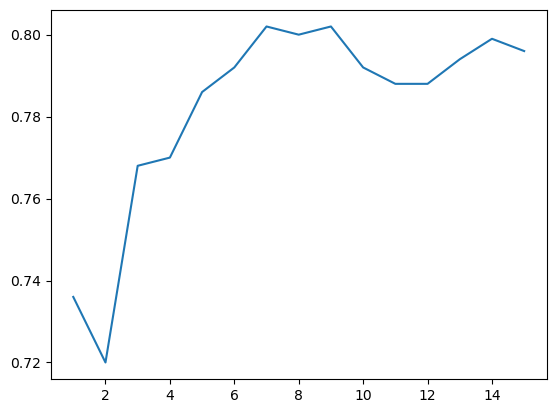

In [16]:
#zoning
n = 15
best_zoning_k = choosing_k(X_train_zoning, X_test_zoning, y_train, y_test, n)
print("The best k for knn in zoning is: ", best_zoning_k)

The best k for knn in histogram is:  12


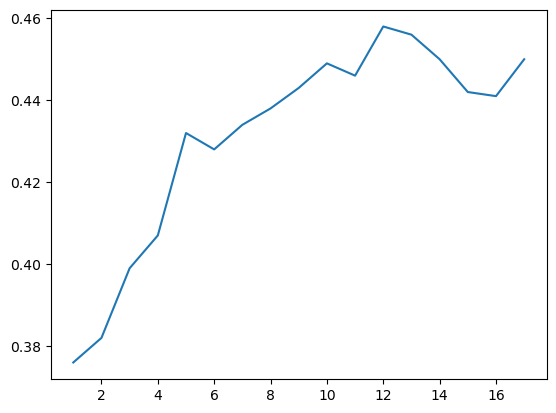

In [17]:
#histogrm
n = 17
best_hist_k = choosing_k(X_train_hist, X_test_hist, y_train, y_test, n)
print("The best k for knn in histogram is: ", best_hist_k)

### Classification with zoning feature extraction

In [18]:
y_pred = knn(X_train_zoning, X_test_zoning, y_train, y_test, 1)
report(y_test, y_pred, "zoning", "1-nn")
y_pred = knn(X_train_zoning, X_test_zoning, y_train, y_test, best_zoning_k)
report(y_test, y_pred, "zoning", "knn")
y_pred = bayes(X_train_zoning, X_test_zoning, y_train, y_test)
report(y_test, y_pred, "zoning", "Bayes")
y_pred = decision_tree(X_train_zoning, X_test_zoning, y_train, y_test)
report(y_test, y_pred, "zoning", "Decision Tree")
y_pred = random_forest(X_train_zoning, X_test_zoning, y_train, y_test)
report(y_test, y_pred, "zoning", "Random Rorest")

1-nn classification report:

               precision    recall  f1-score   support

           0       0.69      0.42      0.52        86
           1       0.65      0.58      0.61        95
           2       0.62      0.64      0.63       110
           3       0.69      0.71      0.70       108
           4       0.58      0.64      0.61        97
           5       0.82      0.88      0.85        93
           6       0.66      0.77      0.71        87
           7       0.92      0.90      0.91       119
           8       0.90      0.84      0.87       113
           9       0.77      0.92      0.84        92

    accuracy                           0.74      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.74      0.74      0.73      1000

----------------------------------------------------------
----------------------------------------------------------

Accuracy of zoning feature: 73.60%
---------------------------------------------------------

### Classification with hsitogram feature extraction

In [19]:
y_pred = knn(X_train_hist, X_test_hist, y_train, y_test, 1)
report(y_test, y_pred, "histogram", "1-nn")
y_pred = knn(X_train_hist, X_test_hist, y_train, y_test, best_hist_k)
report(y_test, y_pred, "histogram", "knn")
y_pred = bayes(X_train_hist, X_test_hist, y_train, y_test)
report(y_test, y_pred, "histogram", "bayes")
y_pred = decision_tree(X_train_hist, X_test_hist, y_train, y_test)
report(y_test, y_pred, "histogram", "decision_tree")
y_pred = random_forest(X_train_hist, X_test_hist, y_train, y_test)
report(y_test, y_pred, "histogram", "random_forest")

1-nn classification report:

               precision    recall  f1-score   support

           0       0.34      0.17      0.23        86
           1       0.52      0.28      0.37        95
           2       0.35      0.27      0.31       110
           3       0.53      0.53      0.53       108
           4       0.47      0.21      0.29        97
           5       0.45      0.52      0.48        93
           6       0.23      0.29      0.26        87
           7       0.30      0.49      0.37       119
           8       0.27      0.37      0.31       113
           9       0.52      0.59      0.55        92

    accuracy                           0.38      1000
   macro avg       0.40      0.37      0.37      1000
weighted avg       0.40      0.38      0.37      1000

----------------------------------------------------------
----------------------------------------------------------

Accuracy of histogram feature: 37.60%
------------------------------------------------------

# Adding noise

In [20]:
def add_salt_and_pepper_noise(image, noise_ratio):
    noisy_image = np.zeros(image.shape)
    for img in image:
        temp = img.copy()
        total_pixels = img.size
        num_salt = int(total_pixels * noise_ratio)
        salt_coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
        temp[salt_coords] = 255  # Set pixels to maximum value (salt)

        num_pepper = int(total_pixels * noise_ratio)
        pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
        temp[pepper_coords] = 0  # Set pixels to minimum value (pepper)
        noisy_image[i] = temp
    return noisy_image

In [21]:
noise_ratio = 0.1
X_test_noisy_zoning = add_salt_and_pepper_noise(X_test_zoning, noise_ratio)
X_test_noisy_hist = add_salt_and_pepper_noise(X_test_hist, noise_ratio)

The best k for knn in zoning is:  4


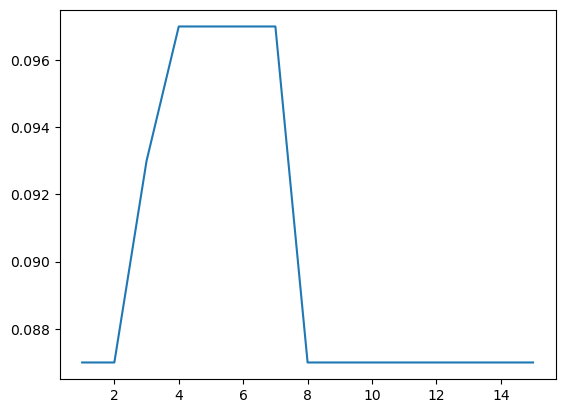

In [22]:
#zoning
n = 15
best_zoning_noisy_k = choosing_k(X_train_zoning, X_test_noisy_zoning, y_train, y_test, n)
print("The best k for knn in zoning is: ", best_zoning_noisy_k)

The best k for knn in histogram is:  3


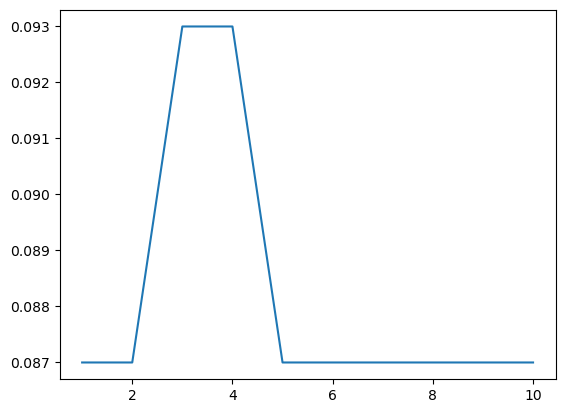

In [23]:
#histogrm
n = 10
best_hist_noisy_k = choosing_k(X_train_hist, X_test_noisy_hist, y_train, y_test, n)
print("The best k for knn in histogram is: ", best_hist_noisy_k)

### Classification with zoning feature extraction in noisy data

In [24]:
y_pred = knn(X_train_zoning, X_test_noisy_zoning, y_train, y_test, 1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of zoning feature for 1-nn classifier: {accuracy*100:.2f}%")
y_pred = knn(X_train_zoning, X_test_noisy_zoning, y_train, y_test, best_zoning_noisy_k)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of zoning feature for knn classifier: {accuracy*100:.2f}%")
y_pred = bayes(X_train_zoning, X_test_noisy_zoning, y_train, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of zoning feature for bayes classifier: {accuracy*100:.2f}%")
y_pred = decision_tree(X_train_zoning, X_test_noisy_zoning, y_train, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of zoning feature for decision_tree classifier: {accuracy*100:.2f}%")
y_pred = random_forest(X_train_zoning, X_test_noisy_zoning, y_train, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of zoning feature for random_forest classifier: {accuracy*100:.2f}%")

Accuracy of zoning feature for 1-nn classifier: 8.70%
Accuracy of zoning feature for knn classifier: 9.70%
Accuracy of zoning feature for bayes classifier: 8.70%
Accuracy of zoning feature for decision_tree classifier: 9.70%
Accuracy of zoning feature for random_forest classifier: 10.80%


### Classification with histogram feature extraction in noisy data

In [25]:
y_pred = knn(X_train_hist, X_test_noisy_hist, y_train, y_test, 1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of histogram feature for 1-nn classifier: {accuracy*100:.2f}%")
y_pred = knn(X_train_hist, X_test_noisy_hist, y_train, y_test, best_hist_noisy_k)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of histogram feature for knn classifier: {accuracy*100:.2f}%")
y_pred = bayes(X_train_hist, X_test_noisy_hist, y_train, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of histogram feature for bayes classifier: {accuracy*100:.2f}%")
y_pred = decision_tree(X_train_hist, X_test_noisy_hist, y_train, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of histogram feature for decision_tree classifier: {accuracy*100:.2f}%")
y_pred = random_forest(X_train_hist, X_test_noisy_hist, y_train, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of histogram feature for random_forest classifier: {accuracy*100:.2f}%")

Accuracy of histogram feature for 1-nn classifier: 8.70%
Accuracy of histogram feature for knn classifier: 9.30%
Accuracy of histogram feature for bayes classifier: 10.80%
Accuracy of histogram feature for decision_tree classifier: 9.70%
Accuracy of histogram feature for random_forest classifier: 8.70%


# different training size

In [26]:
n = 10
m = 5 #Number of Classifiers
diff_acc_zoning = np.zeros((n,m))
diff_acc_hist = np.zeros((n,m))

for i in range(n):
    training_size = 300*(i+1)
    diff_X_train_zoning = X_train_zoning[0:training_size]
    diff_X_train_hist = X_train_hist[0:training_size]
    diff_y_train = y_train[0:training_size]
    
    
    y_pred = knn(diff_X_train_zoning, X_test_zoning, diff_y_train, y_test, 1)
    diff_acc_zoning[i,0] = accuracy_score(y_test, y_pred)

    y_pred = knn(diff_X_train_zoning, X_test_zoning, diff_y_train, y_test, best_zoning_k)
    diff_acc_zoning[i,1] = accuracy_score(y_test, y_pred)

    y_pred = bayes(diff_X_train_zoning, X_test_zoning, diff_y_train, y_test)
    diff_acc_zoning[i,2] = accuracy_score(y_test, y_pred)

    y_pred = decision_tree(diff_X_train_zoning, X_test_zoning, diff_y_train, y_test)
    diff_acc_zoning[i,3] = accuracy_score(y_test, y_pred)

    y_pred = random_forest(diff_X_train_zoning, X_test_zoning, diff_y_train, y_test)
    diff_acc_zoning[i,4] = accuracy_score(y_test, y_pred)
    
    y_pred = knn(diff_X_train_hist, X_test_hist, diff_y_train, y_test, 1)
    diff_acc_hist[i,0] = accuracy_score(y_test, y_pred)

    y_pred = knn(diff_X_train_hist, X_test_hist, diff_y_train, y_test, best_zoning_k)
    diff_acc_hist[i,1] = accuracy_score(y_test, y_pred)

    y_pred = bayes(diff_X_train_hist, X_test_hist, diff_y_train, y_test)
    diff_acc_hist[i,2] = accuracy_score(y_test, y_pred)

    y_pred = decision_tree(diff_X_train_hist, X_test_hist, diff_y_train, y_test)
    diff_acc_hist[i,3] = accuracy_score(y_test, y_pred)

    y_pred = random_forest(diff_X_train_hist, X_test_hist, diff_y_train, y_test)
    diff_acc_hist[i,4] = accuracy_score(y_test, y_pred)

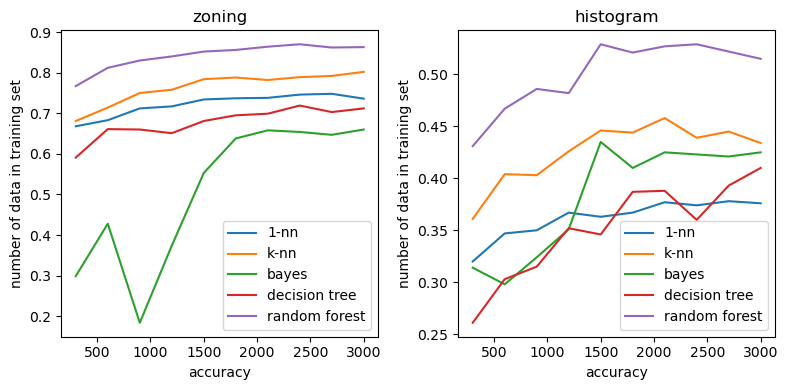

In [27]:
x = range(300,3300,300)
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(x,diff_acc_zoning[:,0])
plt.plot(x,diff_acc_zoning[:,1])
plt.plot(x,diff_acc_zoning[:,2])
plt.plot(x,diff_acc_zoning[:,3])
plt.plot(x,diff_acc_zoning[:,4])
plt.title("zoning")
plt.xlabel("accuracy")
plt.ylabel("number of data in training set")
plt.legend(("1-nn","k-nn","bayes","decision tree","random forest"))

plt.subplot(1,2,2)
plt.plot(x,diff_acc_hist[:,0])
plt.plot(x,diff_acc_hist[:,1])
plt.plot(x,diff_acc_hist[:,2])
plt.plot(x,diff_acc_hist[:,3])
plt.plot(x,diff_acc_hist[:,4])
plt.title("histogram")
plt.xlabel("accuracy")
plt.ylabel("number of data in training set")
plt.legend(("1-nn","k-nn","bayes","decision tree","random forest"))

plt.tight_layout()  
plt.show()